Copyright (C) 2019 Willy Po-Wei Wu <maya6282@gmail.com> and Elvis Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [9]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd

from utils import run_from_ipython, np2df

if run_from_ipython():
    import matplotlib
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [10]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--gpu', help='use GPU', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    parser.add_argument('--temp', '-t', help='temp path', type=str, default='./temp')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', gpu=False, n_folds=10, output='./data_p', result='./result', scheme='address', temp='./temp')


In [11]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
gpu = args.gpu
output_path = args.output
result_path = args.result
temp_path = args.temp

# Check the experiment setting

assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
assert scheme in ['address', 'entity']

# Number of epochs to train
# The specified epochs are enough to converge for each scheme
if scheme == 'address':
    epochs = 4000
elif scheme == 'entity':
    epochs = 1500

# Show the experiment setting

print('Experiment Setting')
print('===> Feature Types:  ', feature_type)
print('===> Data Scheme:    ', scheme)
print('===> Use GPU:        ', gpu)
print('===> Training epochs:', epochs)

Experiment Setting
===> Feature Types:   bem
===> Data Scheme:     address
===> Use GPU:         False
===> Training epochs: 4000


In [12]:
# Load transaction history summarization data

data_file = 'data.{}.csv'.format(scheme)
data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(5)
else:
    print(data.head(5))

      n_tx  total_days  total_spent_btc  total_received_btc  total_spent_usd  \
0      1.0         1.0         0.010000            0.010000         2.756730   
1      1.0         1.0         0.011000            0.011000         2.462163   
2      1.0         1.0         0.010000            0.010000         3.279240   
3      1.0         1.0         0.010521            0.010521         3.947436   
4      1.0         1.0         0.010001            0.010001         2.734935   
...    ...         ...              ...                 ...              ...   
6631   1.0         1.0         1.000000            1.000000       219.158997   
6632   8.0        70.0         2.071500            2.071500       496.212535   
6633   2.0         2.0         0.360000            0.360000       138.339377   
6634  15.0        90.0        21.957800           21.957800      5390.795085   
6635   1.0         1.0         4.873600            4.873600      1826.552194   

      total_received_usd  mean_balance_

In [13]:
# Define 3 types of features (basic statistics, extra statistics, and moments)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
y_names = class_names[y]
print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

6636 6636 64


{'Exchange': 0, 'Faucet': 1, 'Gambling': 2, 'Market': 3, 'Mixer': 4, 'Pool': 5}
Counter({2: 2018, 5: 1410, 1: 971, 3: 880, 0: 770, 4: 587})


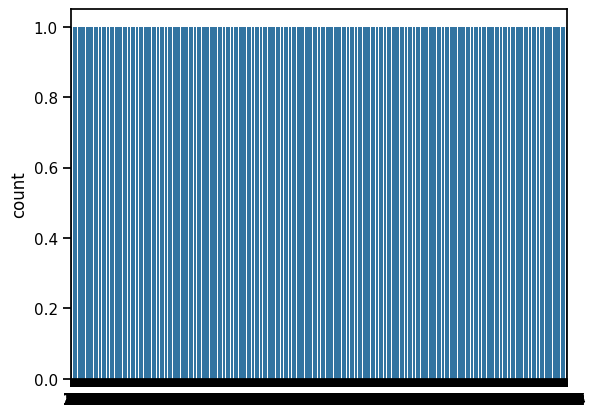

In [14]:
def data_distribution(df):
    if run_from_ipython():
        plt.figure()
        sns.countplot(df.index)
    cnt = collections.Counter(df.index)
    print(cnt)
    return np.array([cnt[i] for i in range(len(cnt))])

print(class2label)
y_count = data_distribution(np2df(X, y))

In [15]:
import os
import pickle
import shutil
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

# 如果不想使用 GPU，可以設置環境變量
if not gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# GPU 配置 for TensorFlow 2.x
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 為每個 GPU 設置允許記憶體增長
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def build_model(input_size, num_classes, summary=False):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_size,)),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(512, activation='relu'),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(512, activation='relu'),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(512, activation='relu'),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if summary:
        model.summary()
    return model


In [16]:
# 訓練過程
train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []

# 宣告 K-Fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# 標準化資料
print('Normalizing data...')
X = np.nan_to_num((X - np.mean(X, axis=0)) / np.std(X, axis=0))
X = np.clip(X, np.percentile(X, 1, axis=0), np.percentile(X, 99, axis=0))

# 開始交叉驗證
for i, (train_idx, valid_idx) in tqdm(enumerate(skf.split(X, y))):
    # 取得分割的訓練集和驗證集
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    y_train_ = keras.utils.to_categorical(y_train, num_classes=len(class2label))
    y_valid_ = keras.utils.to_categorical(y_valid, num_classes=len(class2label))
    
    # 建立模型
    model = build_model(X.shape[1], len(label2class), summary=(i==0))
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 訓練模型
    acc = -1
    for epoch in range(epochs):
        model.train_on_batch(X_train, y_train_)
        accs = model.test_on_batch(X_valid, y_valid_)
        if accs[1] > acc:
            acc = accs[1]
            print(acc, epoch)
            model.save(os.path.join(temp_path, 'model.h5'))
    model = load_model(os.path.join(temp_path, 'model.h5'))
    
    # 在訓練集上評估
    y_pred = np.argmax(model.predict(X_train), axis=1)
    cm = confusion_matrix(y_train, y_pred)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  # 防止除零
    cm = cm / cm_sum
    train_cm_list.append(cm)
    
    # 在驗證集上評估
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)

# 清除臨時檔案
shutil.rmtree(temp_path)

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_9780\4022075598.py:12: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - np.mean(X, axis=0)) / np.std(X, axis=0))


Normalizing data...


0it [00:00, ?it/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               33280     
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)              

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.2620481848716736 1
0.2936747074127197 2
0.32981929183006287 3
0.33433735370635986 4
0.33734938502311707 5
0.4246987998485565 6
0.4277108311653137 7
0.4337349534034729 8
0.4352409541606903 12
0.4382530152797699 19
0.4412650465965271 20
0.4427710771560669 23
0.4442771077156067 43
0.4457831382751465 50
0.4472891688346863 86
0.4503012001514435 117
0.4518072307109833 136
0.45331326127052307 221
0.45481929183006287 475
0.4563252925872803 570
0.45783132314682007 654
0.45933735370635986 709
0.46234938502311707 733
0.46536144614219666 784
0.46686747670173645 1844
0.47138553857803345 1878
0.47590360045433044 2037
0.4819277226924896 3075
0.4864457845687866 3144
0.4894578456878662 3421
0.4924698770046234 3875
0.495481938123703 3902
0.5015060305595398 3909
21/21 [==============================] - 0s 1ms/step


1it [11:59, 719.57s/it]

0.16867469251155853 0
0.23192770779132843 1


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.2439759075641632 2
0.2575301229953766 3
0.2635542154312134 4
0.2650602459907532 5
0.3855421543121338 6
0.3870481848716736 7
0.3885542154312134 8
0.39457830786705017 9
0.39608433842658997 10
0.40813252329826355 11
0.41415661573410034 13
0.41566264629364014 15
0.42168673872947693 19
0.4231927692890167 25
0.4262048304080963 28
0.4277108311653137 30
0.4292168617248535 74
0.4307228922843933 86
0.4322289228439331 96
0.4352409541606903 118
0.4367469847202301 128
0.4382530152797699 131
0.4397590458393097 148
0.4427710771560669 196
0.4442771077156067 204
0.4457831382751465 205
0.4472891688346863 249
0.4487951695919037 252
0.4503012001514435 253
0.4518072307109833 264
0.4563252925872803 266
0.45783132314682007 479
0.45933735370635986 501
0.46536144614219666 554
0.47439759969711304 699
0.47590360045433044 1565
0.48042169213294983 1797
0.4924698770046234 1983
21/21 [==============================] - 0s 1ms/step


2it [23:56, 717.88s/it]

0.17771084606647491 0
0.22289156913757324 1


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.2439759075641632 2
0.26656627655029297 3
0.27861446142196655 4
0.29518070816993713 5
0.3268072307109833 6
0.33885541558265686 7
0.4277108311653137 9
0.4292168617248535 10
0.4352409541606903 11
0.4412650465965271 12
0.4427710771560669 24
0.4442771077156067 126
0.4457831382751465 131
0.4472891688346863 158
0.4487951695919037 197
0.4503012001514435 214
0.4518072307109833 228
0.45331326127052307 230
0.45783132314682007 413
0.45933735370635986 451
0.46084338426589966 457
0.46536144614219666 476
0.46686747670173645 794
0.46837350726127625 846
0.47138553857803345 933
0.47891566157341003 976
0.4819277226924896 1997
0.4849397540092468 2111
0.4909638464450836 2441
0.4984939694404602 2939
0.5030120611190796 3111
21/21 [==============================] - 0s 1ms/step


3it [35:57, 719.22s/it]

0.17319276928901672 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.25 1
0.3087349534034729 2
0.3177710771560669 3
0.32831326127052307 4
0.33433735370635986 5
0.33584338426589966 6
0.34186747670173645 7
0.34487950801849365 11
0.34939759969711304 12
0.35240963101387024 13
0.3569277226924896 18
0.35843372344970703 20
0.3614457845687866 26
0.3674698770046234 30
0.3689759075641632 31
0.3719879388809204 38
0.3734939694404602 45
0.375 70
0.4292168617248535 73
0.45331326127052307 74
0.45933735370635986 77
0.46234938502311707 105
0.46536144614219666 111
0.46837350726127625 121
0.46987950801849365 139
0.47138553857803345 170
0.47289156913757324 178
0.47439759969711304 195
0.47740963101387024 202
0.47891566157341003 206
0.48343372344970703 390
0.4849397540092468 404
0.4864457845687866 468
0.4879518151283264 868
0.4909638464450836 959
0.495481938123703 1308
0.5 1756
0.5030120611190796 2757
0.509036123752594 3441
21/21 [==============================] - 0s 3ms/step


4it [47:56, 719.32s/it]

0.32831326127052307 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.41415661573410034 4
0.4277108311653137 5
0.4322289228439331 11
0.4352409541606903 20
0.4412650465965271 22
0.4472891688346863 30
0.4487951695919037 342
0.4518072307109833 464
0.45481929183006287 537
0.45933735370635986 593
0.46084338426589966 688
0.46385541558265686 740
0.46837350726127625 824
0.46987950801849365 876
0.47138553857803345 896
0.47590360045433044 962
0.47740963101387024 1648
0.47891566157341003 3232
0.48343372344970703 3243
0.4849397540092468 3416
0.4864457845687866 3596
0.4909638464450836 3605
0.4939759075641632 3889
21/21 [==============================] - 0s 4ms/step


5it [1:10:30, 948.01s/it]

0.1882530152797699 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.23343373835086823 1
0.2454819232225418 2
0.27710843086242676 3
0.3117469847202301 4
0.3207831382751465 5
0.3268072307109833 6
0.32981929183006287 7
0.33584338426589966 8
0.34487950801849365 9
0.40210843086242676 10
0.41265061497688293 11
0.41415661573410034 12
0.42018070816993713 13
0.42168673872947693 16
0.4307228922843933 18
0.4322289228439331 25
0.4352409541606903 26
0.4367469847202301 140
0.4382530152797699 242
0.4412650465965271 243
0.4427710771560669 272
0.4442771077156067 292
0.4457831382751465 340
0.4487951695919037 398
0.4503012001514435 857
0.4518072307109833 939
0.45783132314682007 989
0.45933735370635986 1095
0.46234938502311707 1115
0.46385541558265686 1118
0.46686747670173645 1459
0.47138553857803345 1584
0.47740963101387024 2215
0.4819277226924896 2670
0.4849397540092468 3589
21/21 [==============================] - 0s 3ms/step


6it [1:28:44, 997.80s/it]

0.22775264084339142 0
0.2730015218257904 1


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.28959277272224426 2
0.3061840236186981 3
0.31674209237098694 4
0.322775274515152 5
0.3333333432674408 6
0.4012066423892975 7
0.4147813022136688 8
0.4162895977497101 9
0.41779789328575134 11
0.4193061888217926 12
0.4223227798938751 13
0.4238310754299164 14
0.42533937096595764 15
0.4268476665019989 255
0.42835596203804016 288
0.4298642575740814 345
0.4313725531101227 346
0.43288084864616394 399
0.4343891441822052 407
0.43589743971824646 412
0.4374057352542877 414
0.44343891739845276 485
0.444947212934494 544
0.4494720995426178 724
0.4570135772228241 793
0.4600301682949066 901
0.4615384638309479 1133
0.4690799415111542 1894
0.47058823704719543 2172
0.47360482811927795 2364
0.47812971472740173 2391
0.4901960790157318 2573
0.4977375566959381 2792
21/21 [==============================] - 0s 1ms/step


7it [1:41:03, 913.26s/it]

0.2654600441455841 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.30467572808265686 1
0.34690800309181213 2
0.35444948077201843 3
0.4298642575740814 5
0.4313725531101227 6
0.43288084864616394 7
0.43589743971824646 8
0.438914030790329 10
0.4419306218624115 12
0.444947212934494 23
0.4464555084705353 27
0.4494720995426178 36
0.4539969861507416 37
0.4570135772228241 77
0.4600301682949066 79
0.4615384638309479 87
0.46304675936698914 109
0.4645550549030304 120
0.46606335043907166 130
0.4690799415111542 132
0.47058823704719543 139
0.4751131236553192 145
0.479638010263443 159
0.48114630579948425 367
0.48567119240760803 394
0.4871794879436493 401
0.48868778347969055 406
0.49170437455177307 1092
0.49321267008781433 1179
0.4947209656238556 1362
0.5022624731063843 3165
21/21 [==============================] - 0s 1ms/step


8it [1:53:17, 856.01s/it]

0.10558069497346878 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.16591252386569977 1
0.30165913701057434 2
0.3107089102268219 3
0.3303167521953583 4
0.33936652541160583 5
0.42081448435783386 7
0.4268476665019989 10
0.4343891441822052 11
0.4539969861507416 12
0.45550528168678284 17
0.4570135772228241 18
0.45852187275886536 24
0.4615384638309479 25
0.4675716459751129 26
0.4690799415111542 58
0.47058823704719543 63
0.4720965325832367 70
0.47360482811927795 74
0.4751131236553192 75
0.4766214191913605 84
0.47812971472740173 96
0.479638010263443 117
0.4826546013355255 127
0.48567119240760803 152
0.4871794879436493 202
0.4901960790157318 208
0.49170437455177307 229
0.49321267008781433 414
0.4947209656238556 417
0.49622926115989685 476
0.4977375566959381 523
0.500754177570343 535
0.5022624731063843 632
0.5052790641784668 633
0.5067873597145081 888
0.5113122463226318 944


8it [2:05:05, 938.14s/it]


KeyboardInterrupt: 

In [ ]:
# Save training results

experiment_name = os.path.join(result_path, 'nn.{}.{}'.format(feature_type, scheme))
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

In [ ]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [ ]:
# Average classification report of training set in K-fold

print('Average classification report of training set in {:d}-fold'.format(n_folds))
show_rp_list(train_rp_list)

In [ ]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

In [ ]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)